In [ ]:
!pip install tsp_solver2

In [ ]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import collections
from tsp_solver.greedy import solve_tsp
import os

In [ ]:
!mkdir Data

In [ ]:
!git clone https://github.com/baiqiushi/cs271p.git

Cloning into 'cs271p'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 195.01 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (197/197), done.


In [ ]:
!python cs271p/genTSP.py -n 15 -k 100 -u 400 -v 100

generating 1 problems with parameters: N=15, K=100, U=400, V=100...
generation is done.


In [ ]:
temp = []
with open("input.txt", "r") as f:
  temp = f.readlines()

In [ ]:
temp = [x[:-1].split() for x in temp[1:]]

In [ ]:
temp = [[float(y) for y in x] for x in temp]

In [ ]:
class Fitness:
    def __init__(self, route, matrix):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
        self.matrix = matrix
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += self.matrix[fromCity][toCity]
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [ ]:
def createRoute(num_cities):
    route = random.sample(list(range(num_cities)), num_cities)
    return route

In [ ]:
def cmp_key(c):
  lst = temp[c]
  lst = lst[:c]+lst[c+1:]
  return np.argmin(lst)

def create_a_path_n(num_cities):
    cities = list(range(num_cities))
    city = random.sample(cities,1)[0]
    path = [city]
    remaining_cities = [rc for rc in cities if rc!=city]
    #loop while the list of remaining cities are not empty
    while remaining_cities:
        #get the minimum distance
        city = min(remaining_cities, key=cmp_key)
        path.append(city)
        remaining_cities.remove(city)
    return path

In [ ]:
def initialPopulation(popSize, matrix):
    population = []
    num_cities = len(matrix)
    for i in range(0, popSize-1):
        population.append(create_a_path_n(num_cities))
    
    # path = solve_tsp(temp)
    # population.append(path)
    return population

In [ ]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i], matrix).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [ ]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [ ]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [ ]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP2[:startGene] + childP1 + childP2[startGene:]
    return child

In [ ]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [ ]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [ ]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [ ]:
def nextGeneration(currentGen, eliteSize, mutationRate, greedy = False):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    if not greedy:
      return nextGeneration

    path = solve_tsp(temp)
    nextGeneration.pop()
    nextGeneration.append(path)
    return nextGeneration

In [ ]:
early_stop = collections.deque(maxlen=50)

In [ ]:
def geneticAlgorithm(matrix, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, matrix)
    progress = []
    progress1 = []
    last_distance =  1 / rankRoutes(pop)[0][1]
    min_distance = last_distance
    early_stop.append(last_distance)
    progress.append(last_distance)
    best_route = pop[rankRoutes(pop)[0][0]]
    
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))    
    
    for i in tqdm(range(0, generations)):
      if i == 400:
        pop = nextGeneration(pop, eliteSize, mutationRate, greedy=True)
      else:
        pop = nextGeneration(pop, eliteSize, mutationRate)

      last_distance = 1 / rankRoutes(pop)[0][1]
      
      #store the best route
      if last_distance < min_distance:
        min_distance = last_distance
        best_route = pop[rankRoutes(pop)[0][0]]

      #early stop
      progress1.append(abs(last_distance - min(early_stop)))
      if abs(last_distance - max(early_stop))<0.00000001 and i > 500:
        break

      progress.append(last_distance)
      early_stop.append(last_distance)

    
    print("Final distance: " + str(min_distance))
    return progress, best_route, min_distance, progress1, i

In [ ]:
progress, best_route, min_distance, progress1, num_episodes = geneticAlgorithm(population=temp, popSize=100, eliteSize=20, 
                                                                mutationRate=0.1/len(temp), generations=1000)

Initial distance: 5496.781853963475


Final distance: 4331.564356764927


In [ ]:
def bestRoute(adjacency_matrix):
  progress1, bestRoute1, min_distance1 = geneticAlgorithm(population=adjacency_matrix, popSize=100, eliteSize=20, 
                                                          mutationRate=0.1/len(temp), 
                                                          generations=10000)
  progress2, bestRoute2, min_distance2 = geneticAlgorithm(population=adjacency_matrix, popSize=100, eliteSize=20, 
                                                          mutationRate=0, 
                                                          generations=1000)
  progress3, bestRoute3, min_distance3 = geneticAlgorithm(population=adjacency_matrix, popSize=100, eliteSize=20, 
                                                          mutationRate=0.1/len(temp), 
                                                          generations=10000)
  
  if min_distance1 < min_distance2:
    if min_distance1 < min_distance3:
      return progress1, bestRoute1, min_distance1
    else:
      return progress3, bestRoute3, min_distance3
  else:
    if min_distance2 < min_distance3:
      return progress2, bestRoute2, min_distance2
    else:
      return progress3, bestRoute3, min_distance3

In [ ]:
# progress, bestRoute, min_distance = bestRoute(temp)

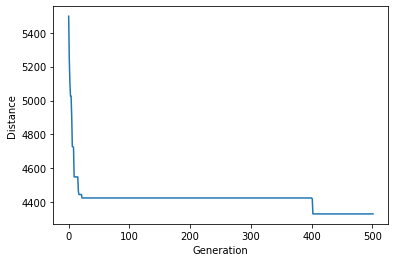

In [ ]:
plt.plot(progress)
plt.ylabel('Distance')
plt.xlabel('Generation')
plt.show()

In [ ]:
# Python3 program to solve  
# Traveling Salesman Problem using  
# Branch and Bound. 
import math 
maxsize = float('inf') 
  
# Function to copy temporary solution 
# to the final solution 
def copyToFinal(curr_path): 
    final_path[:N + 1] = curr_path[:] 
    final_path[N] = curr_path[0] 
  
# Function to find the minimum edge cost  
# having an end at the vertex i 
def firstMin(adj, i): 
    min = maxsize 
    for k in range(N): 
        if adj[i][k] < min and i != k: 
            min = adj[i][k] 
  
    return min
  
# function to find the second minimum edge  
# cost having an end at the vertex i 
def secondMin(adj, i): 
    first, second = maxsize, maxsize 
    for j in range(N): 
        if i == j: 
            continue
        if adj[i][j] <= first: 
            second = first 
            first = adj[i][j] 
  
        elif(adj[i][j] <= second and 
             adj[i][j] != first): 
            second = adj[i][j] 
  
    return second 
  
# function that takes as arguments: 
# curr_bound -> lower bound of the root node 
# curr_weight-> stores the weight of the path so far 
# level-> current level while moving 
# in the search space tree 
# curr_path[] -> where the solution is being stored 
# which would later be copied to final_path[] 
def TSPRec(adj, curr_bound, curr_weight,  
              level, curr_path, visited): 
    global final_res 
      
    # base case is when we have reached level N  
    # which means we have covered all the nodes once 
    if level == N: 
          
        # check if there is an edge from 
        # last vertex in path back to the first vertex 
        if adj[curr_path[level - 1]][curr_path[0]] != 0: 
              
            # curr_res has the total weight 
            # of the solution we got 
            curr_res = curr_weight + adj[curr_path[level - 1]][curr_path[0]] 
            if curr_res < final_res: 
                copyToFinal(curr_path) 
                final_res = curr_res 
        return
  
    # for any other level iterate for all vertices 
    # to build the search space tree recursively 
    for i in range(N): 
          
        # Consider next vertex if it is not same  
        # (diagonal entry in adjacency matrix and  
        #  not visited already) 
        if (adj[curr_path[level-1]][i] != 0 and
                            visited[i] == False): 
            temp = curr_bound 
            curr_weight += adj[curr_path[level - 1]][i] 
  
            # different computation of curr_bound  
            # for level 2 from the other levels 
            if level == 1: 
                curr_bound -= ((firstMin(adj, curr_path[level - 1]) + 
                                firstMin(adj, i)) / 2) 
            else: 
                curr_bound -= ((secondMin(adj, curr_path[level - 1]) +
                                 firstMin(adj, i)) / 2) 
  
            # curr_bound + curr_weight is the actual lower bound  
            # for the node that we have arrived on. 
            # If current lower bound < final_res,  
            # we need to explore the node further 
            if curr_bound + curr_weight < final_res: 
                curr_path[level] = i 
                visited[i] = True
                  
                # call TSPRec for the next level 
                TSPRec(adj, curr_bound, curr_weight,  
                       level + 1, curr_path, visited) 
  
            # Else we have to prune the node by resetting  
            # all changes to curr_weight and curr_bound 
            curr_weight -= adj[curr_path[level - 1]][i] 
            curr_bound = temp 
  
            # Also reset the visited array 
            visited = [False] * len(visited) 
            for j in range(level): 
                if curr_path[j] != -1: 
                    visited[curr_path[j]] = True
  
# This function sets up final_path 
def TSP(adj): 
      
    # Calculate initial lower bound for the root node  
    # using the formula 1/2 * (sum of first min +  
    # second min) for all edges. Also initialize the  
    # curr_path and visited array 
    curr_bound = 0
    curr_path = [-1] * (N + 1) 
    visited = [False] * N 
  
    # Compute initial bound 
    for i in range(N): 
        curr_bound += (firstMin(adj, i) + 
                       secondMin(adj, i)) 
  
    # Rounding off the lower bound to an integer 
    curr_bound = math.ceil(curr_bound / 2) 
  
    # We start at vertex 1 so the first vertex  
    # in curr_path[] is 0 
    visited[0] = True
    curr_path[0] = 0
  
    # Call to TSPRec for curr_weight  
    # equal to 0 and level 1 
    TSPRec(adj, curr_bound, 0, 1, curr_path, visited) 
  
# Driver code 
  
# Adjacency matrix for the given graph 
adj = temp
N = len(temp)
  
# final_path[] stores the final solution  
# i.e. the // path of the salesman. 
final_path = [None] * (N + 1) 
  
# visited[] keeps track of the already 
# visited nodes in a particular path 
visited = [False] * N 
  
# Stores the final minimum weight 
# of shortest tour. 
final_res = maxsize 
  
TSP(adj) 
  
print("Minimum cost :", final_res) 
print("Path Taken : ", end = ' ') 
for i in range(N + 1): 
    print(final_path[i], end = ' ') 
  
# This code is contributed by ng24_7

Minimum cost : 4271.358045119162
Path Taken :  0 4 7 12 2 8 5 11 3 13 10 1 6 9 14 0 

In [ ]:
best_route

[2, 8, 6, 1, 10, 13, 3, 5, 11, 14, 0, 7, 4, 9, 12]

In [ ]:
#Greedy TSP
path = solve_tsp(temp)
Fitness(path).routeDistance()+temp[path[-1]][path[0]]

4949.045268119521

In [ ]:
temp[7][2]+min_distance

4860.462648244525